# Loading data from Digital Earth Africa

This section provides an overview of loading data to use in the Digital Earth Africa Sandbox. The Earth observation data is hosted as an [Open Data Cube](https://www.opendatacube.org/), which makes it accessible to users of the DE Africa Sandbox.

In this section, we will:

1. Load the `datacube` package so we can connect to the datacube.
2. Connect to the datacube to access the data.
3. Use the `load.ard` function to pull data from the datacube.
4. Inspect the loaded data.

This will be followed by sections on how to plot, manipulate and analyse the data.

## Load `datacube` package

First, we need to load packages that allow access to key datacube and Sandbox functions. The `datacube` package allows us to query and load from the datacube database. We must also import the `Scripts` folder, which allows us to use useful Sandbox code utilities.

In [1]:
import datacube

# Import utilities
import sys
sys.path.append('../../Scripts')

## Connect to the datacube

To access the Earth observation data, we need to connect to the datacube database. This can be done using the `datacube` package we just imported. Let us call the datacube object `dc`; in the next step, we will be able to call upon `dc` to load data.

Note the `app` parameter is a unique name used to identify the notebook, and does not have any effect on the analysis. In this case, we have simply named it `Loading_data`.

In [2]:
dc = datacube.Datacube(app="Loading_data")

## Load data using `load_ard`

Datacube data can be loaded through two methods:

* `dc.load`: This is the standard datacube load function. It will not be covered in this section &mdash; details can be found in `03_Loading_data.ipynb` in the **Beginners_guide** folder of the Sandbox (GitHub version [here](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Beginners_guide/03_Loading_data.ipynb)). `dc.load` is also explained in the Open Data Cube documentation [here](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html).
* `load_ard`: This is the preferred data-loading function for the DE Africa Sandbox and will be used in this section. It can combine data from multiple related products, and automatically mask out missing or undesireable data. This makes it ideal for loading Landsat and Sentinel-2 products.

`load_ard` is preferred for loading Landsat products `ls5_usgs_sr_scene`, `ls7_usgs_sr_scene`, `ls8_usgs_sr_scene`, and `ga_ls8c_fractional_cover_2` and the Sentinel-2 product `s2_l2a`.

To review all the products available on the Sandbox, and their datacube aliases, see section 1 in this session on Sandbox products - `01_data_available`. You may also find the `02_Products_and_measurements.ipynb` notebook in the **Beginners_guide** folder of the sandbox useful (GitHub version [here](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Beginners_guide/02_Products_and_measurements.ipynb)).

For additional detail, examples, and information on `load_ard`, see `Using_load_ard.ipynb` in the **Frequently_used_code** folder of the Sandbox (GitHub version [here](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Frequently_used_code/Using_load_ard.ipynb)).

### `load_ard` syntax

The `load_ard()` function requires, at minimum, the arguments listed below. Each argument is followed by an example of its use &mdash; later, we will put together the entire query and try loading some data.

|Compulsory arguments| Description | Example|
|----------|----------------|-------|
| `dc` | A `datacube.Datacube` instance used to query the datacube. We will define this as the connection we made to the datacube earlier (also called `dc`).| `dc=dc`|
| `products`| A list of the products we want to load data from.| `products=["ls7_usgs_sr_scene", "ls8_usgs_sr_scene"]`|
| `x` |Defines the spatial region we want to load data from, in the *x* dimension, using latitude coordinates. |`x=(39.20, 39.37)`|
| `y`| Defines the spatial region we want to load data from, in the *y* dimension, using longitude coordinates. | `y=(-6.90, -6.70)`|
`time` |Defines the temporal extent. The time dimension can be specified using a tuple of datetime objects or strings in the *YYYY*, *YYYY-MM* or *YYYY-MM-DD* format.| `time=("2018-01-01", "2018-12-31")` |
`output_crs` | The Coordinate Reference System (CRS) of the output dataset.|`output_crs="EPSG:4326"`|
`resolution` |A 2-tuple of the `y` and `x` resolutions (in that order) in pixels per degree. The first value is typically negative. |`resolution=(-0.00027, 0.00027)` ||

By default, the *x* and *y* arguments accept queries in a geographical coordinate system WGS84, identified by the EPSG code `4326`, and the dimensions `longitude`/`latitude` and `x`/`y` can be used interchangeably. If you would like to use a different Coordinate Reference System (CRS), specify the CRS with the `crs` argument.

The example value used for `resolution` is `(-0.00027, 0.00027)`. This gives a resolution of 30 metres per pixel, which is the native resolution of Landsat 5, 7, and 8.

Finally, we have some optional but useful arguments.

|Optional arguments| Description | Example|
|----------|----------------|-------|
| `min_gooddata` | This stands for 'minimum good data' and discards observations with less than the fractional requisite of good quality pixels. | `min_gooddata=0.7`|
| `group_by`| Use the `solar day` option to combine instances of multiple observations per day into one observation per day. | `group_by='solar_day'`||

When combined into a load query, arguments are separated by commas.

### Example: Landsat data in Tanzania

Before we can begin using `load_ard`, we need to import the `load_ard` function.

In [3]:
from deafrica_datahandling import load_ard

Let's run a query to load Landsat 7 and 8 data for Dar es Salaam, Tanzania in 2018.
These are the products we'll load data from:
- Landsat 7: [ls7_usgs_sr_scene](https://explorer.digitalearth.africa/ls7_usgs_sr_scene)
- Landsat 8: [ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

It is often useful to re-use a set of query parameters to load data from multiple products.
To achieve this, we can load data using the 'query dictionary' syntax.
This involves placing the query parameters inside a Python dictionary object which we can re-use for multiple data loads.

In [4]:
query = dict(dc=dc,
             min_gooddata=0.7,
             x=(39.20, 39.37),
             y=(-6.90, -6.70),
             time=("2018-01-01", "2018-12-31"),
             output_crs="EPSG:4326",
             resolution=(-0.00027, 0.00027),
             group_by='solar_day')

We can then use this query dictionary object as an input to `load_ard()`. 

> The `**` syntax below is Python's 'keyword argument unpacking' operator.
This operator takes the named query parameters listed in the dictionary we created (e.g. `x=(39.20, 39.37)`), and 'unpacks' them into the `load_ard()` function as new arguments. 
For more information about unpacking operators, refer to the [Python documentation](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists).

Let's call our Landsat dataset `landsat_ds`.

In [5]:
landsat_ds = load_ard(products=["ls7_usgs_sr_scene", "ls8_usgs_sr_scene"],
                      **query)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls7_usgs_sr_scene
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 4 out of 41 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


### Example: Sentinel-2 data in Tanzania

Now let's run a query to load Sentinel-2 data for Dar es Salaam, Tanzania in 2018. We can call our Sentinel-2 dataset `sentinel_2_ds`. We will call upon the product:

* Sentinel-2: [s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

Notice we have changed the `products` argument, but the `**query` draws on the same parameters we defined for the previous data load.

In [6]:
sentinel_2_ds = load_ard(products=["s2_l2a"],
                         **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 24 out of 71 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 24 time steps


We have now successfully loaded the data. It does not display automatically, so we will view it in the next step.

## Interpret the loaded data

Loading the data using `load_ard` results in data formatted as an `xarray.Dataset`. Therefore, the variable `landsat_ds` and `sentinel_2_ds` are `xarray.Dataset` objects containing all data that matched the query parameters (spatial, temporal, product, etc.) inputted into `load_ard()` commands above.

Executing the dataset name will show details of the dataset.

|`xarray.Dataset` component| Description |
|--------------------|----------------|
| Dimensions |  Identifies the number of timesteps returned in the search (`time`) as well as the number of pixels in the `x` and `y` dimensions of the data query.|
|Coordinates| `time` identifies the date attributed to each returned timestep. `x` and `y` are the coordinates for each pixel within the spatial bounds of your query. |
Data variables |These are the measurements available for the nominated product.  For every date (`time`) returned by the query, the measured value at each pixel (`y`, `x`) is returned as an array for each measurement. Each data variable is itself an `xarray.DataArray` object, which is further described [below](#Inspect-an-individual-xarray.DataArray). |
Attributes| `crs` identifies the CRS of the loaded data. It should match the `output_crs` specified in the `load_ard` query.||

In [7]:
landsat_ds

<xarray.Dataset>
Dimensions:      (latitude: 742, longitude: 630, time: 4)
Coordinates:
    spatial_ref  int32 4326
  * latitude     (latitude) float64 -6.7 -6.7 -6.7 -6.701 ... -6.899 -6.9 -6.9
  * longitude    (longitude) float64 39.2 39.2 39.2 39.2 ... 39.37 39.37 39.37
  * time         (time) datetime64[ns] 2018-01-31T07:31:54.636976 ... 2018-12-01T07:31:56.186494
Data variables:
    blue         (time, latitude, longitude) float32 nan nan nan ... 443.0 704.0
    green        (time, latitude, longitude) float32 nan nan nan ... 534.0 857.0
    red          (time, latitude, longitude) float32 nan nan nan ... 594.0 969.0
    nir          (time, latitude, longitude) float32 nan nan ... 1245.0 1967.0
    swir1        (time, latitude, longitude) float32 nan nan ... 1355.0 2326.0
    swir2        (time, latitude, longitude) float32 nan nan ... 991.0 1689.0
    radsat_qa    (time, latitude, longitude) float32 nan nan nan ... 0.0 0.0 0.0
    pixel_qa     (time, latitude, longitude) uint16 328 328 328 ... 322 322 322
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Inspect an individual `xarray.DataArray`
The `xarray.Dataset` objects we loaded above are collections of individual `xarray.DataArray` objects that hold the data for each data variable/measurement. For example, all measurements listed under `Data variables` above (e.g. `blue`, `green`, `red`, `nir`, `swir1`, `swir2`) are `xarray.DataArray` objects.

We can inspect the data in these `xarray.DataArray` objects for an `xarra.Dataset` named `ds` using either of the following syntaxes:
```
ds["measurement_name"]
```
or:
```
ds.measurement_name
```

Being able to access data from individual data variables/measurements allows us to manipulate and analyse data from individual satellite bands or specific layers in a dataset. 
For example, we can access the Landsat data from the near infrared satellite band, `nir`:

In [8]:
landsat_ds.nir

<xarray.DataArray 'nir' (time: 4, latitude: 742, longitude: 630)>
array([[[  nan,   nan,   nan, ...,  148.,  170.,  219.],
        [  nan,   nan,   nan, ...,  141.,  167.,  224.],
        [  nan,   nan,   nan, ...,  145.,  174.,  232.],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[3376., 2545., 2431., ...,  223.,  207.,  219.],
        [2677., 2432., 2337., ...,  205.,  206.,  208.],
        [2525., 2405., 2720., ...,  201.,  205.,  210.],
        ...,
        [3119., 2948., 2614., ..., 3014., 3091., 3032.],
        [3436., 3416., 2806., ..., 2905., 2676., 3132.],
        [3022., 3487., 3183., ..., 2851., 2529., 3146.]],

       [[2656., 2235., 2235., ...,  238.,  238.,  238.],
        [2445., 2235., 2319., ...,  238.,  280.,  238.],
        [  nan,   nan,   nan, ...,  238.,  238.,  238.],
        ...,
        [2492., 2281., 2197., ..., 2446., 2488., 2320.],
        [2661., 2451., 2027., ..., 2403., 2446., 2362.],
        [2661., 2704., 2366., ..., 2403., 2362., 2320.]],

       [[  nan,   nan,   nan, ...,  153.,  153.,  150.],
        [  nan,   nan,   nan, ...,  124.,  140.,  143.],
        [  nan,   nan,   nan, ...,  143.,  148.,  147.],
        ...,
        [3699., 3109., 2804., ..., 2648., 2992., 3104.],
        [3294., 3304., 3058., ..., 1725., 2066., 2820.],
        [2829., 3267., 3399., ..., 1592., 1245., 1967.]]], dtype=float32)
Coordinates:
    spatial_ref  int32 4326
  * latitude     (latitude) float64 -6.7 -6.7 -6.7 -6.701 ... -6.899 -6.9 -6.9
  * longitude    (longitude) float64 39.2 39.2 39.2 39.2 ... 39.37 39.37 39.37
  * time         (time) datetime64[ns] 2018-01-31T07:31:54.636976 ... 2018-12-01T07:31:56.186494
Attributes:
    units:         reflectance
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

Note that the object header informs us that it is an `xarray.DataArray` containing data for the `nir` satellite band. 

Like an `xarray.Dataset`, the array also includes information about the data's **dimensions** (i.e. `(time: 4, latitude: 742, longitude: 630)`), **coordinates** and **attributes**.

For a more in-depth introduction to `xarray` data structures, refer to the [official xarray documentation](http://xarray.pydata.org/en/stable/data-structures.html), or take a look at the notebook `07_Intro_to_xarray.ipynb` in the **Beginners_guide** folder of the Sandbox (GitHub version [here](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Beginners_guide/07_Intro_to_xarray.ipynb)).

## Showing RGB representations of the data

Below are RGB images of the Landsat and Sentinel-2 data. The white pixels are locations of missing or unclean data. In the case of Landsat and Sentinel-2 data loaded with `load_ard()`, these areas are usually clouds or cloud shadow.

In the next section

### Landsat

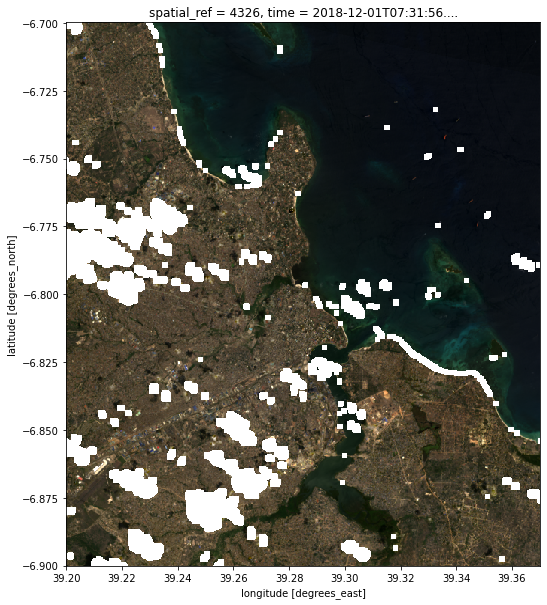

In [9]:
from deafrica_plotting import rgb

rgb(landsat_ds.isel(time=3), bands=['red', 'green', 'blue'], vmin=0, vmax=4000, size=10)

### Sentinel-2

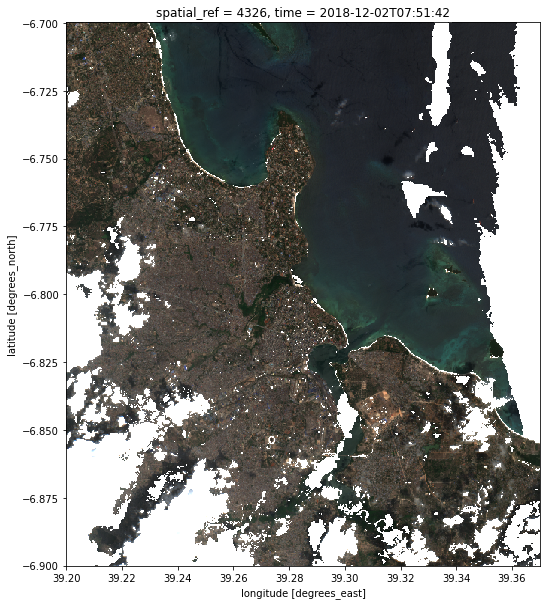

In [10]:
rgb(sentinel_2_ds.isel(time=21), bands=['B04', 'B03', 'B02'], vmin=0, vmax=5000, size=10)